In [33]:
from grab_db import my_db
import numpy as np
import pandas as pd
import sklearn.preprocessing
from zillow_wrangle import my_train_test_split, clean_zillow, plot_variable_pairs, plot_categorical_and_continuous_vars, get_zillow_data
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
from scipy.stats import pearsonr, spearmanr
from sklearn.linear_model import LinearRegression
from evaluate import plot_residuals, regression_errors, baseline_mean_errors, better_than_baseline
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures

In [3]:
zillow = get_zillow_data()

In [4]:
zillow = clean_zillow(zillow)

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,location,age
564018,1.0,3.0,1373.0,46093.0,0,75.0
2131776,3.0,5.0,2668.0,320600.0,0,19.0
1384152,2.0,4.0,2048.0,365818.0,0,102.0
577743,1.0,3.0,936.0,253220.0,1,76.0
2131422,3.0,3.0,3166.0,592709.0,1,33.0
...,...,...,...,...,...,...
1864178,3.0,5.0,2736.0,275000.0,0,17.0
1094831,2.0,3.0,1560.0,346956.0,0,27.0
946271,2.0,3.0,1905.0,355145.0,0,75.0
134615,1.0,2.0,1011.0,340688.0,0,100.0


In [36]:
train, validate, test = my_train_test_split(zillow)
x_train = train.drop(columns = 'taxvaluedollarcnt')
y_train = train.taxvaluedollarcnt
x_validate = validate.drop(columns = 'taxvaluedollarcnt')
y_validate = validate.taxvaluedollarcnt
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
x_test = test.drop(columns = 'taxvaluedollarcnt')
y_test = test.taxvaluedollarcnt
y_test = pd.DataFrame(y_test)

# Baseline

In [7]:
train['baseline'] = train.taxvaluedollarcnt.mean()
baseline = train.taxvaluedollarcnt.mean()

In [8]:
taxval_pred_mean = y_train.taxvaluedollarcnt.mean()

In [9]:
taxval_pred_mean

461142.90497409547

In [40]:
y_train['taxval_pred_mean'] = taxval_pred_mean
y_validate['taxval_pred_mean'] = taxval_pred_mean

In [11]:
taxval_pred_median = y_train.taxvaluedollarcnt.median()


In [12]:
y_train['taxval_pred_median'] = taxval_pred_median
y_validate['taxval_pred_median'] = taxval_pred_median

In [13]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_mean)**(1/2)

In [14]:
rmse_train

680490.0709134196

In [15]:
rmse_validate

684136.3426535855

In [16]:
print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Mean
Train/In-Sample:  680490.07 
Validate/Out-of-Sample:  684136.34


In [17]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt,y_train.taxval_pred_median) ** (1/2)
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_median) **(1/2)

In [20]:
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2),
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))


RMSE using Median
Train/In-Sample:  693417.91 
Validate/Out-of-Sample:  696721.87


# OLS:

In [22]:
lm = LinearRegression(normalize=True)

In [23]:
lm.fit(x_train, y_train.taxvaluedollarcnt)

LinearRegression(normalize=True)

In [42]:
y_train['taxval_pred_lm'] = lm.predict(x_train)

In [27]:
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_lm)**(1/2)

In [43]:
y_validate['taxval_pred_lm'] = lm.predict(x_validate)

In [30]:
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm)**(1/2)

In [31]:
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  526425.8474194795 
Validation/Out-of-Sample:  535627.9236657922


In [34]:
# create the model object
lars = LassoLars(alpha=1.0)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lars.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_lars'] = lars.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_lars)**(1/2)

# predict validate
y_validate['taxval_pred_lars'] = lars.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Lasso + Lars
Training/In-Sample:  526436.5049920856 
Validation/Out-of-Sample:  535650.2198496001


In [45]:
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
glm.fit(x_train, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_glm'] = glm.predict(x_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_glm)**(1/2)

# predict validate
y_validate['taxval_pred_glm'] = glm.predict(x_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  680490.0709134196 
Validation/Out-of-Sample:  684136.3426535855


In [37]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
x_train_degree2 = pf.fit_transform(x_train)

# transform X_validate_scaled & X_test_scaled
x_validate_degree2 = pf.transform(x_validate)
x_test_degree2 = pf.transform(x_test)


In [38]:
# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train,
# since we have converted it to a dataframe from a series!
lm2.fit(x_train_degree2, y_train.taxvaluedollarcnt)

# predict train
y_train['taxval_pred_lm2'] = lm2.predict(x_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.taxvaluedollarcnt, y_train.taxval_pred_lm2)**(1/2)

# predict validate
y_validate['taxval_pred_lm2'] = lm2.predict(x_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train,
      "\nValidation/Out-of-Sample: ", rmse_validate)


RMSE for Polynomial Model, degrees=2
Training/In-Sample:  494515.1602956864 
Validation/Out-of-Sample:  498766.13871578383


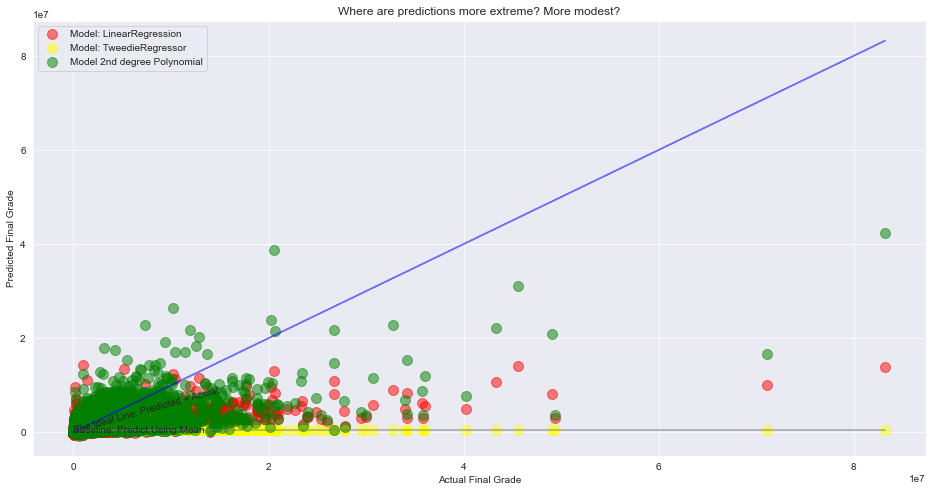

In [46]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.taxvaluedollarcnt, y_validate.taxvaluedollarcnt, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm,
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_glm,
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm2,
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Predicted Final Grade")
plt.title("Where are predictions more extreme? More modest?")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()


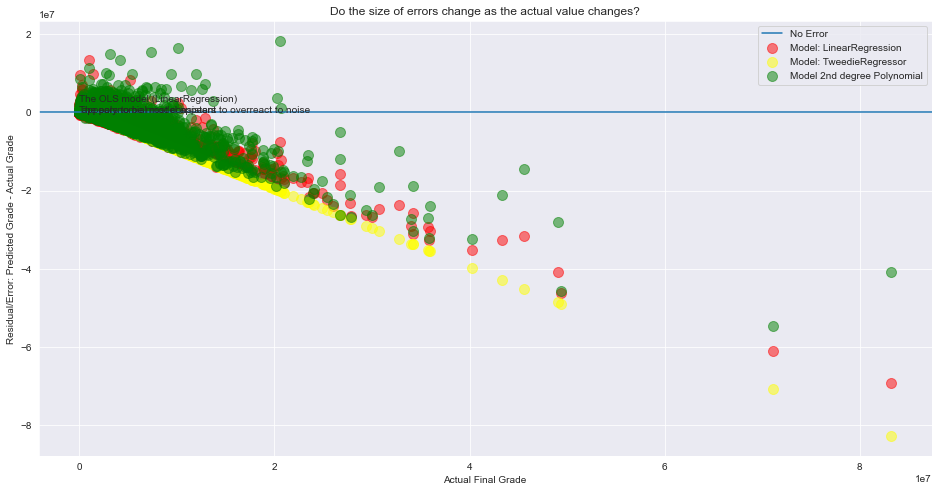

In [49]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm-y_validate.taxvaluedollarcnt,
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_glm-y_validate.taxvaluedollarcnt,
            alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.taxvaluedollarcnt, y_validate.taxval_pred_lm2-y_validate.taxvaluedollarcnt,
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Final Grade")
plt.ylabel("Residual/Error: Predicted Grade - Actual Grade")
plt.title("Do the size of errors change as the actual value changes?")
plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()
